In [ ]:
#1.Why feature scaling is important for the k-means algorithm?
    #Feature scaling is important because if you're data is operating on different scales, it will result in innaccurate results
    #It's sensitive to mean and variance so if your data isn't normalized, it will throw your numbers off!
#2. How can clustering be used to improve the performance of a linear model?
    #f. All of the above
        #a.Creating different models for different cluster groups.
        #b.Creating an input feature for cluster ids as an ordinal variable.
        #c.Creating an input feature for cluster centroids as a continuous variable.
        #d.Creating an input feature for cluster size as a continuous variable.
#3. What are the risks of initial random cluster centroids assignments in k-means?
    #Majority of the time it doesn't lead to the best solution. K-means is senetive to the cluster centroids and if the values are changed,
    #you will get different reults. Because of this, it's common to run the model multile times and find averages or SSE's of the centroid 
    #and from there decide which ones will give you the best solution to proceed with. 

In [1]:
import boto3
import pandas as pd; pd.set_option('display.max_column', 100)
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt



s3= boto3.resource('s3')
bucket_name= 'morgangant-bata-445-bucket'
bucket= s3.Bucket(bucket_name)

file_key= 'Mall_Customers.csv'

bucket_object= bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

#reading the datefile
customers = pd.read_csv(file_content_stream)
customers.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [2]:
customers= customers.dropna()

In [3]:
customers= customers.drop(columns= ['CustomerID', 'Spending Score (1-100)'], axis=1)
#Changing Gender Male/Female to 1/0
customers['Gender'].replace(['Male', 'Female'], [1,0], inplace= True)
customers.head()

,Gender,Age,Annual Income (k$)
0,1,19,15
1,1,21,15
2,0,20,16
3,0,23,16
4,0,31,17


In [4]:
#standardizing data
scaler= MinMaxScaler().fit(customers)
x= scaler.transform(customers)
x

array([[1.        , 0.01923077, 0.        ],
       [1.        , 0.05769231, 0.        ],
       [0.        , 0.03846154, 0.00819672],
       [0.        , 0.09615385, 0.00819672],
       [0.        , 0.25      , 0.01639344],
       [0.        , 0.07692308, 0.01639344],
       [0.        , 0.32692308, 0.02459016],
       [0.        , 0.09615385, 0.02459016],
       [1.        , 0.88461538, 0.03278689],
       [0.        , 0.23076923, 0.03278689],
       [1.        , 0.94230769, 0.03278689],
       [0.        , 0.32692308, 0.03278689],
       [0.        , 0.76923077, 0.04098361],
       [0.        , 0.11538462, 0.04098361],
       [1.        , 0.36538462, 0.04098361],
       [1.        , 0.07692308, 0.04098361],
       [0.        , 0.32692308, 0.04918033],
       [1.        , 0.03846154, 0.04918033],
       [1.        , 0.65384615, 0.06557377],
       [0.        , 0.32692308, 0.06557377],
       [1.        , 0.32692308, 0.07377049],
       [1.        , 0.13461538, 0.07377049],
       [0.

In [5]:
#defining the numbe rof clusters to be considered
krange= list(range(2,20))

#defining lists to store scores
CH_scores= list()
DB_scores= list()
Sill_scores= list()

for i in krange:

    #Define k-means model
    cluster_md= KMeans(n_clusters= i, n_init= 20).fit(x)
    cluster_assignments= cluster_md.labels_
   
    #extract CH, DB and sill scores
    CH= calinski_harabasz_score(x, cluster_assignments)
    DB= davies_bouldin_score(x, cluster_assignments)
    Sill= silhouette_score(x, cluster_assignments)
    
    #storing scores
    CH_scores.append(CH)
    DB_scores.append(DB)
    Sill_scores.append(Sill)

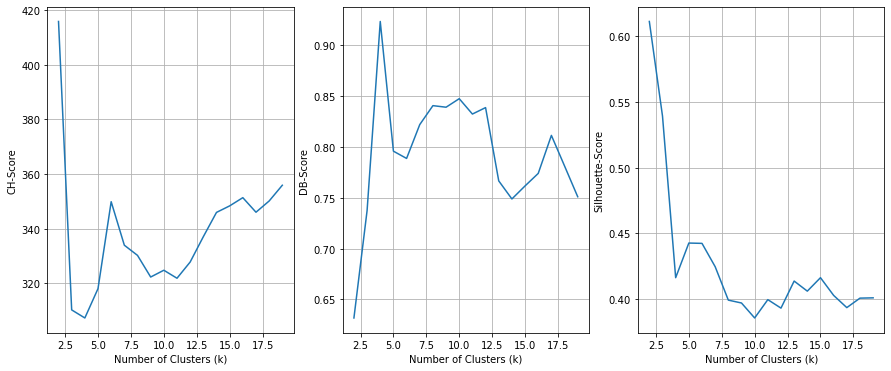

In [78]:
#visulizing the scores
fig, axs = plt.subplots(1, 3, figsize = (15, 6))
axs[0].plot(krange, CH_scores)
axs[0].set_xlabel('Number of Clusters (k)')
axs[0].set_ylabel('CH-Score')
axs[0].grid()

axs[1].plot(krange, DB_scores)
axs[1].set_xlabel('Number of Clusters (k)')
axs[1].set_ylabel('DB-Score')
axs[1].grid()

axs[2].plot(krange, Sill_scores)
axs[2].set_xlabel('Number of Clusters (k)')
axs[2].set_ylabel('Silhouette-Score')
axs[2].grid()

In [ ]:
#CH test says the best number of clusters would be close to two clusters
#DB test says the best number of clusters would be close to two clusters
#Sill test says the best number of clusters would be close to two clusters
#From here, we will build a k-means model with 2 clusters

In [8]:
#Clustering the data
two_clusters= KMeans(n_clusters= 2, n_init= 20).fit(x)

#Append cluster labels 
customers['cluster']= two_clusters.labels_
customers.head(10)

,Gender,Age,Annual Income (k$),cluster
0,1,19,15,1
1,1,21,15,1
2,0,20,16,0
3,0,23,16,0
4,0,31,17,0
5,0,22,17,0
6,0,35,18,0
7,0,23,18,0
8,1,64,19,1
9,0,30,19,0


In [ ]:
#Cluster 1: Females, range young and older(not old old)
#Cluster 2: Males, range young and old
#I don't see a clear distinction between the groups other than gender.
    #Ages have a large range and Annual Income ranges from the 
    #end to end (max to min)
#I think the issue is how little variance there is within the group. It
    #might be better to have three age groups split by age and annual
    #income. I think it could have better clustering that way.